No artifacts
Spectrograms
Time coherence?
3 subjects, should be split?

In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

In [153]:
from biosppy_custom.signals import eeg, emg, tools

In [2]:
import multiprocessing

def multiproc(df, func, n_jobs = None):
    if n_jobs is None:
        n_jobs = multiprocessing.cpu_count()
    num_partitions = n_jobs
    print('Parallelizing into',num_partitions,'batches.')
    df_split = np.array_split(df, num_partitions)
    pool = multiprocessing.Pool(n_jobs)
    df = pd.concat(pool.map(func, df_split))
    pool.close()
    pool.join()
    return df

def prnt_prog(i,n):
    return not i%(n//50) and print("%03d%%"%(i//(n//50)*2), end='\r',flush=True)

# func has to return a dict of features to add to the row
def apply_row_wise(df, func, prefix=''):
    n = len(df)
    rets = [prnt_prog(i,n) or func(row[1]) for i, row in enumerate(df.iterrows())]
    for field in rets[0].keys():
        df[prefix+field] = [r[field] for r in rets]
    return df

In [3]:
import csv
# returns a dict mapping sample id [int] to the raw time series [np.array]
def importTimeSeries(filename):
    datafile = open(filename, 'r')
    datareader = csv.reader(datafile)
    out = dict()
    first = True
    for row in datareader:
        if first:
            first = False
            continue
        out[int(row[0])] = np.asarray(row[1:], dtype=float)
    return out

In [4]:
train_eeg1 = importTimeSeries('train_eeg1.csv')
print('Done: train_eeg1', end='')
train_eeg2 = importTimeSeries('train_eeg2.csv')
print(', train_eeg2', end='')
train_emg  = importTimeSeries('train_emg.csv')
print(', train_emg', end='')
train = pd.read_csv('train_labels.csv').set_index('Id',drop=False)
train['eeg1'] = [train_eeg1[k] for k in train.index.values]
train['eeg2'] = [train_eeg2[k] for k in train.index.values]
train['emg']  = [train_emg [k] for k in train.index.values]
print(' ,train_labels.')
print('Merged into Dataframe: train')

Done: train_eeg1, train_eeg2, train_emg ,train_labels.
Merged into Dataframe: train


In [5]:
del train_eeg1
del train_eeg2
del train_emg

In [6]:
train['individual'] = [id//(len(train)/3) for id in train.Id]

In [7]:
def apply_biosppy_eeg(df): 
    def func(row):
        return eeg.eeg(signal=np.array([row.eeg1,row.eeg2]).transpose(),
                       sampling_rate=128, show=False)
    return apply_row_wise(df, func, 'eeg_')
train = multiproc(train, apply_biosppy_eeg)

Parallelizing into 48 batches.


In [154]:
def apply_biosppy_emg(df): 
    def func(row):
        return emg.emg(signal=np.array(row.emg),
                       sampling_rate=128, show=False, freq=64)
    return apply_row_wise(df, func, 'emg_')
train = multiproc(train, apply_biosppy_emg)

Parallelizing into 48 batches.


In [ ]:
for feat in train.columns:
    if np.shape(train[feat][0])


In [157]:
sig_names =  ['eeg_theta',
              'eeg_alpha_low',
              'eeg_alpha_high',
              'eeg_beta',
              'eeg_gamma',
              'eeg_plf',
              'emg_filtered'
             ]
stats = {'mean':np.mean, 
         'median':np.median, 
         'min':np.min, 
         'max':np.max, 
         'std':np.std,
        }

def stats_on_signals(df):
    def func(row):
        return {(sig_name+'_'+stat_name):np.median(f(row[sig_name],axis=0))
                for sig_name in sig_names
                for (stat_name,f) in stats.items()
               }
    return apply_row_wise(df, func, '')

train = multiproc(train, stats_on_signals, n_jobs=16)

Parallelizing into 16 batches.


# Preprocessing

In [158]:
myfeats = []
for feat in train.columns:
    if feat == 'Id' or feat == 'y' or feat == 'individual': continue
    if np.isscalar(train[feat][0]): myfeats.append(feat)
nfeats = len(myfeats)
print(nfeats)
print(myfeats)

40
['eeg_theta_mean', 'eeg_theta_median', 'eeg_theta_min', 'eeg_theta_max', 'eeg_theta_std', 'eeg_alpha_low_mean', 'eeg_alpha_low_median', 'eeg_alpha_low_min', 'eeg_alpha_low_max', 'eeg_alpha_low_std', 'eeg_alpha_high_mean', 'eeg_alpha_high_median', 'eeg_alpha_high_min', 'eeg_alpha_high_max', 'eeg_alpha_high_std', 'eeg_beta_mean', 'eeg_beta_median', 'eeg_beta_min', 'eeg_beta_max', 'eeg_beta_std', 'eeg_gamma_mean', 'eeg_gamma_median', 'eeg_gamma_min', 'eeg_gamma_max', 'eeg_gamma_std', 'eeg_plf_mean', 'eeg_plf_median', 'eeg_plf_min', 'eeg_plf_max', 'eeg_plf_std', 'emg_mean', 'emg_median', 'emg_min', 'emg_max', 'emg_std', 'emg_filtered_mean', 'emg_filtered_median', 'emg_filtered_min', 'emg_filtered_max', 'emg_filtered_std']


In [159]:
X_raw = train[myfeats].values
y_raw = train['y']
print(np.shape(X_raw))
n_train = len(train)

(64800, 40)


In [160]:
counts = {i:np.sum(y_raw == i) for i in range(1,4)}
weights = {i:float(n_train)/(np.sum(y_raw == i)) for i in range(1,4)}

print(counts)
print(weights)

{1: 34114, 2: 27133, 3: 3553}
{1: 1.8995133962596003, 2: 2.3882357277116428, 3: 18.23810864058542}


In [161]:
from sklearn.model_selection import train_test_split 
X_tr, X_te, y_tr, y_te = train_test_split(X_raw, y_raw, 
                                          test_size=.3, random_state=666
                                          #test_size=0.25
                                         )
n_te = len(y_te)
n_tr = len(y_tr)
print('full :',["%.2f"%(np.mean(y_raw == cl)) for cl in range(1,4)])
print('train:',["%.2f"%(np.mean(y_tr == cl))  for cl in range(1,4)])
print('test :',["%.2f"%(np.mean(y_te == cl))  for cl in range(1,4)])
np.shape(X_tr)

full : ['0.53', '0.42', '0.05']
train: ['0.53', '0.42', '0.05']
test : ['0.53', '0.42', '0.05']


(45360, 40)

# Try fitting one of my beloved Random Forests

In [162]:
import gc
gc.collect()

29

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
tuned_parameters = [{'n_estimators': [400], 
                     'max_depth': [4,5,6], 
                   # 'criterion': ['gini',],
                     'min_samples_split': [90,100,200,500], 
                     'min_samples_leaf': [15], 
                   # 'min_weight_fraction_leaf': [0], 
                   # 'max_features': ['auto'], 
                   # 'max_leaf_nodes': [None],#,100, 300, 500], 
                   # 'min_impurity_decrease': [0], 
                   # 'bootstrap': [True], 
                   # 'oob_score': [False,], 
                   # 'class_weight': [weights]
                    },
                   ]
#scorer = make_scorer(f1_score, average = 'micro')

clf = GridSearchCV(RandomForestClassifier(n_jobs=-1,
                                          class_weight=weights
                                         ),
                   tuned_parameters, 
                   cv=5,
                   scoring='balanced_accuracy',
                   n_jobs =-1, 
                   verbose=10,
                   )

clf.fit(X_tr, y_tr)
print('done')

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   26.3s
[Parallel(n_jobs=-1)]: Done   4 out of  60 | elapsed:   36.4s remaining:  8.5min
[Parallel(n_jobs=-1)]: Done  11 out of  60 | elapsed:   38.0s remaining:  2.8min
[Parallel(n_jobs=-1)]: Done  18 out of  60 | elapsed:   40.5s remaining:  1.6min
[Parallel(n_jobs=-1)]: Done  25 out of  60 | elapsed:   41.5s remaining:   58.0s
[Parallel(n_jobs=-1)]: Done  32 out of  60 | elapsed:   48.7s remaining:   42.6s


In [ ]:
import gc
gc.collect()

In [ ]:
pred_te  = clf.predict(X_te)
pred_tr = clf.predict(X_tr)

In [ ]:
from my_utils import plot_confusion_matrix
from sklearn.metrics import balanced_accuracy_score as bmac
from sklearn.metrics import classification_report 

print("Grid scores on development set:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))
print()

print("Best parameters set found on development set:")
print(clf.best_params_)
print()

print("Detailed classification report:")
samwe = [weights[int(yi)] for yi in y_te]
print(classification_report(y_te, pred_te, sample_weight = samwe))
print()

plot_confusion_matrix(y_te, pred_te, np.array([0,1,2,3]),normalize=True, )
print()
print('What matters:')
print('test  bmac =',   bmac(y_te, pred_te),
      '\ttrain bmac =', bmac(y_tr, pred_tr))



In [147]:
print('Done, go eat')

Done, go eat


# Play around a bit

In [148]:
# USEFUL ANALYIS STUFF
def subsets():
    subs = [
        train[(train.y==y) & (train.individual==indiv)]
        for y in [1,2,3]
        for indiv in [0.,1.,2.]
    ]
    return subs

def randrow(i=-1):
    if i==-1:
        return train.sample(1).iloc[0]
    else:
        return subsets()[i].sample(1).iloc[0]
    
def box(field):
    plt.boxplot([sub[field] for sub in subsets()], whis=[5, 95])
    plt.show()

In [149]:
[(sub.iloc[0].individual,sub.iloc[0].y) for sub in subsets()]

[(0.0, 1),
 (1.0, 1),
 (2.0, 1),
 (-0.0, 2),
 (1.0, 2),
 (2.0, 2),
 (0.0, 3),
 (1.0, 3),
 (2.0, 3)]

Id


/cluster/apps/python/3.6.1/x86_64/lib64/python3.6/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


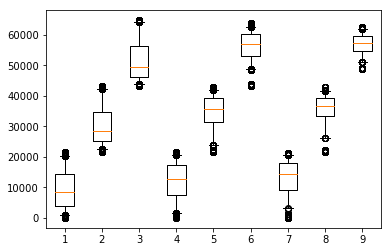

y


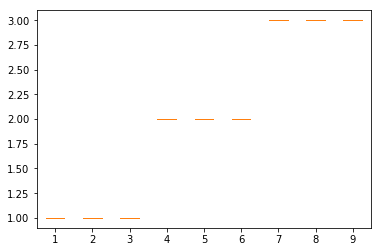

individual


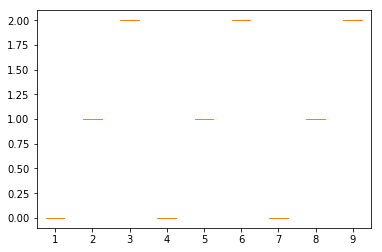

eeg_theta_mean


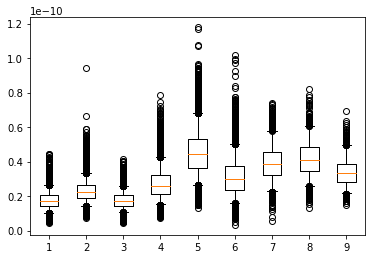

eeg_theta_median


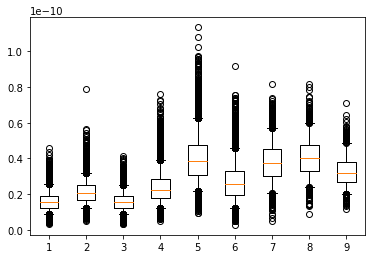

eeg_theta_min


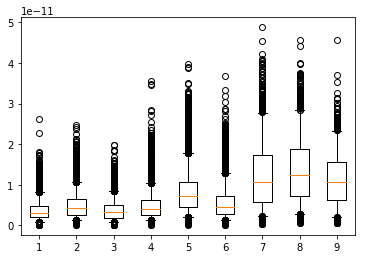

eeg_theta_max


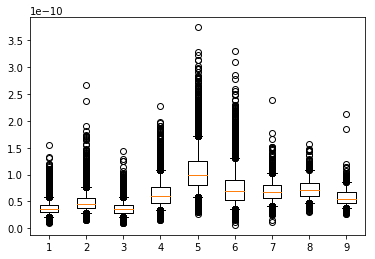

eeg_theta_std


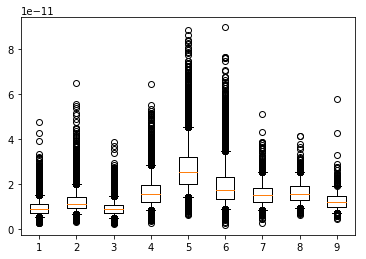

eeg_alpha_low_mean


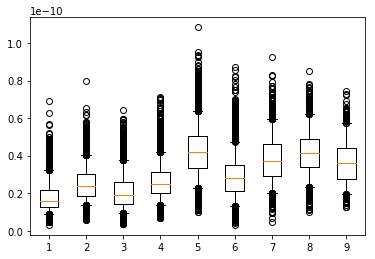

eeg_alpha_low_median


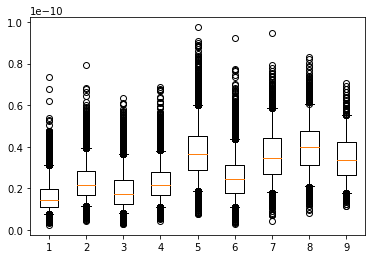

eeg_alpha_low_min


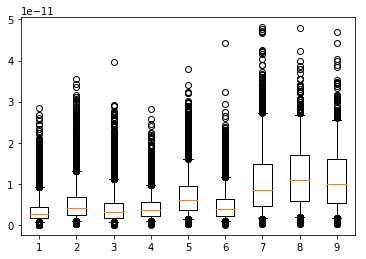

eeg_alpha_low_max


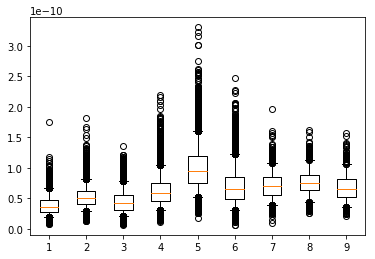

eeg_alpha_low_std


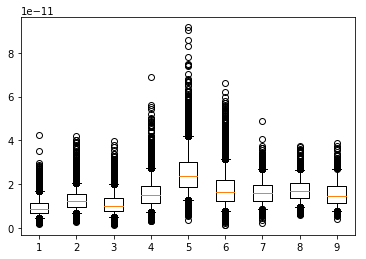

eeg_alpha_high_mean


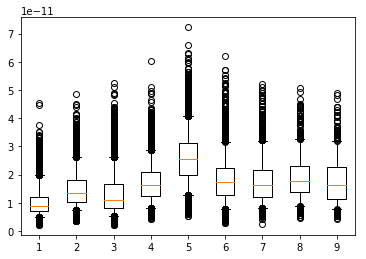

eeg_alpha_high_median


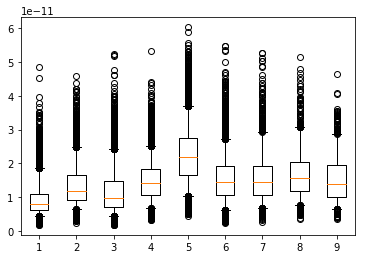

eeg_alpha_high_min


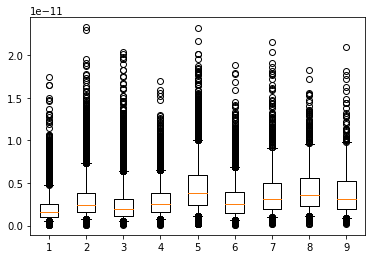

eeg_alpha_high_max


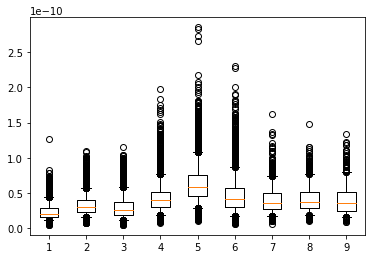

eeg_alpha_high_std


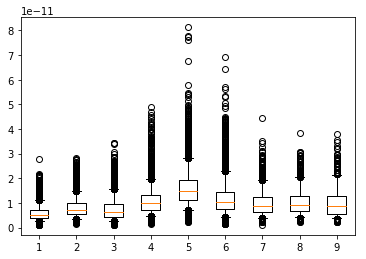

eeg_beta_mean


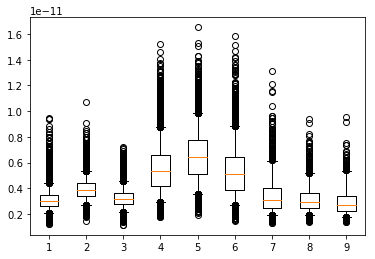

eeg_beta_median


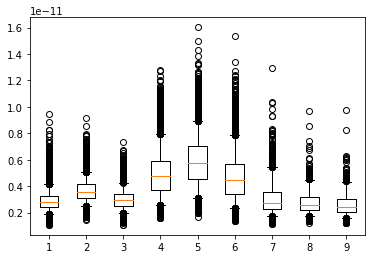

eeg_beta_min


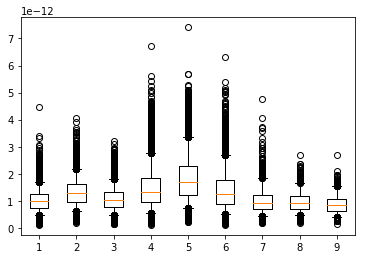

eeg_beta_max


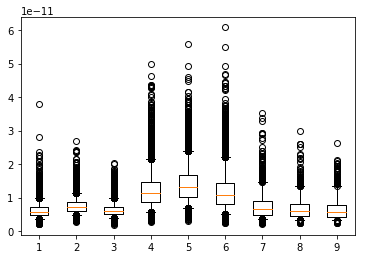

eeg_beta_std


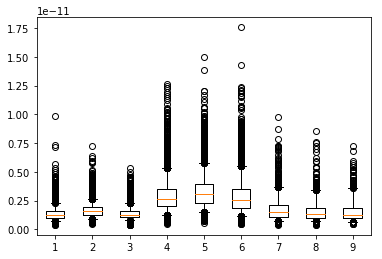

eeg_gamma_mean


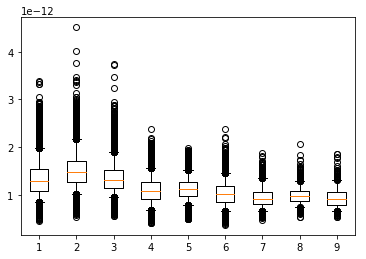

eeg_gamma_median


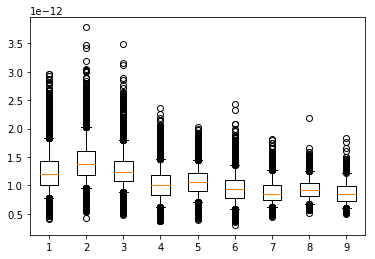

eeg_gamma_min


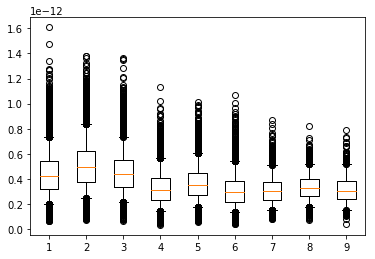

eeg_gamma_max


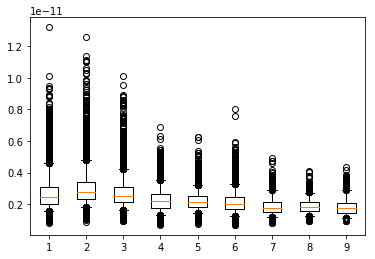

eeg_gamma_std


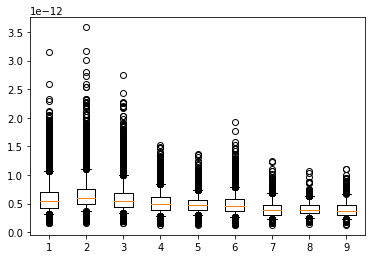

eeg_plf_mean


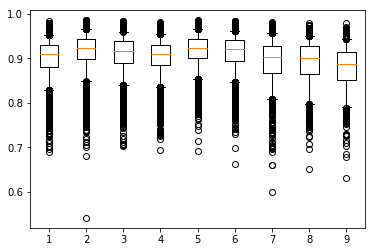

eeg_plf_median


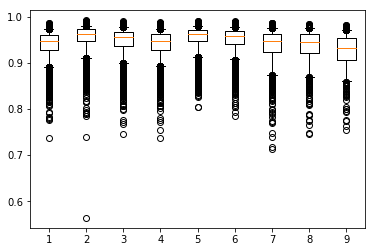

eeg_plf_min


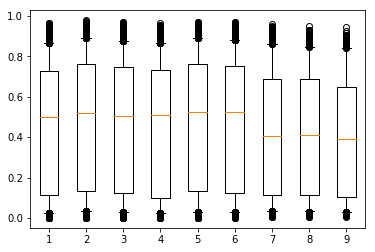

eeg_plf_max


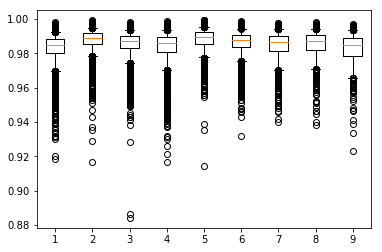

eeg_plf_std


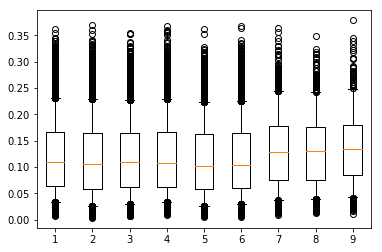

emg_mean


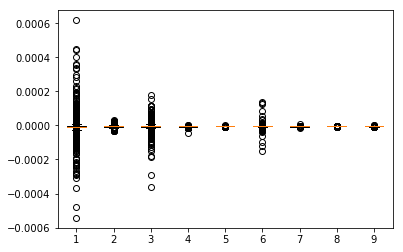

emg_median


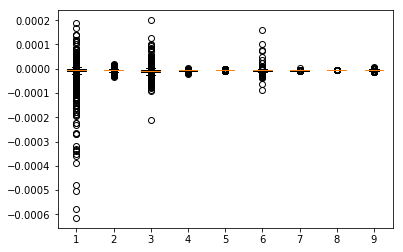

emg_min


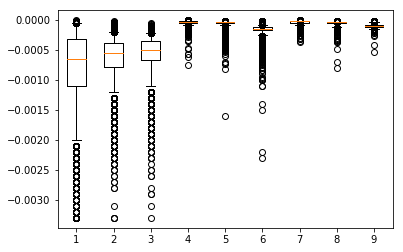

emg_max


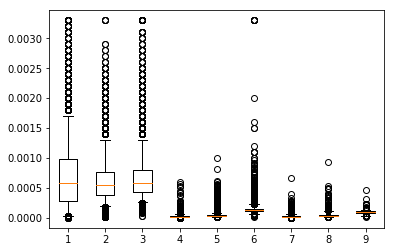

emg_std


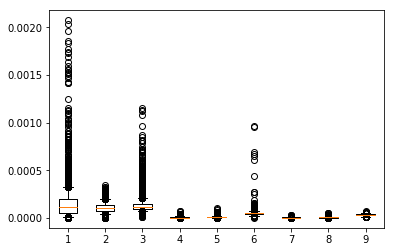

In [150]:
# grouped by class, split by individual
for feat in train.columns:
    if np.isscalar(train[feat][0]):
        print(feat)
        box(feat)

In [156]:
for col in train.columns:
    print('{:<15s} {:<20s}'.format(col, str(np.shape(train.iloc[0][col]))))

Id              ()                  
y               ()                  
eeg1            (512,)              
eeg2            (512,)              
emg             (512,)              
individual      ()                  
eeg_ts          (512,)              
eeg_filtered    (512, 2)            
eeg_features_ts (31,)               
eeg_theta       (31, 2)             
eeg_alpha_low   (31, 2)             
eeg_alpha_high  (31, 2)             
eeg_beta        (31, 2)             
eeg_gamma       (31, 2)             
eeg_plf_pairs   (1, 2)              
eeg_plf         (31, 1)             
eeg_theta_mean  ()                  
eeg_theta_median ()                  
eeg_theta_min   ()                  
eeg_theta_max   ()                  
eeg_theta_std   ()                  
eeg_alpha_low_mean ()                  
eeg_alpha_low_median ()                  
eeg_alpha_low_min ()                  
eeg_alpha_low_max ()                  
eeg_alpha_low_std ()                  
eeg_alpha_high_mean () 

In [24]:
delta = np.diff(train.y)

In [35]:
np.shape(np.append(0, delta))

(64800,)

In [39]:
bef = train[np.append(delta,0)==1].iloc[0:3]
aft = train[np.append(0,delta)==1].iloc[0:3]
print(bef.y)
print('-------')
print(aft.y)

Id
4      2
296    1
300    1
Name: y, dtype: int64
-------
Id
5      3
297    2
301    2
Name: y, dtype: int64


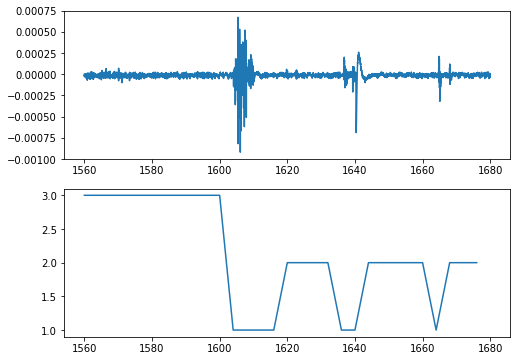

In [134]:
begin = 390
finish = begin+30
start = np.array(range(begin,finish))*4
sample = train.iloc[begin:finish]
time = start + sample['eeg_ts'].values
np.shape(np.concatenate(time))
plt.figure(figsize=(8, 6))
ax1=plt.subplot(311)
ax1.plot(np.concatenate(time),
         np.concatenate(sample['emg'].values[:][:]))
ax2=plt.subplot(312,sharex=ax1)
ax2.plot(start,
         sample['y'])
ax2=plt.subplot(313,sharex=ax1)
ax2.plot(start,
         sample['emg'])
plt.show()

(15360,)

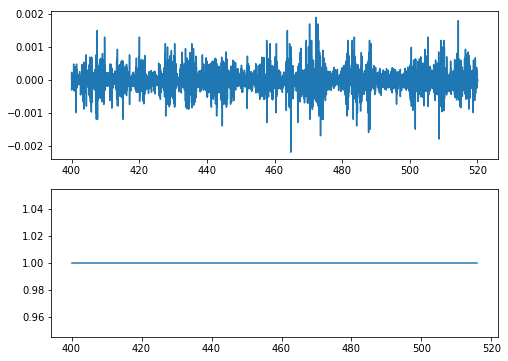

KeyError: 0

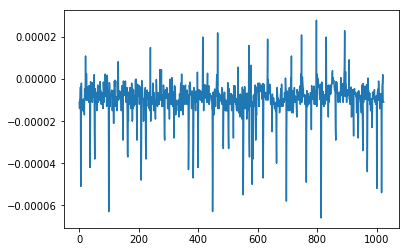

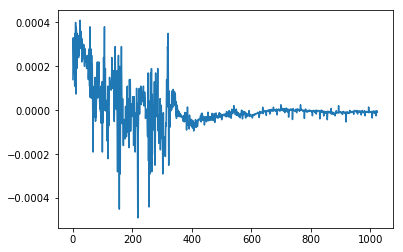

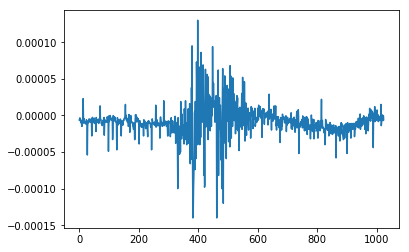

In [51]:
feat = 'emg'
for databef, dataaft in zip(bef[feat], aft[feat]):
    #databef, dataaft = databef[:,0], dataft[:,0]
    plt.plot(np.append(databef, dataaft))
    plt.show()

In [ ]:
np.shape(np.mean(train.eeg_gamma,axis=1))

In [ ]:
row = randrow()
np.array([row.eeg1,row.eeg2]).transpose()

In [ ]:
row = randrow()
a

In [ ]:
row = randrow()
print(row.y)
print(row.eeg_plf_pairs)
plt.plot(row.eeg_plf)

In [ ]:
row = randrow()
print(row.y)
plt.plot(row.eeg_plf)
plt.show()
plt.plot(row.eeg_filtered)
plt.show()
plt.plot(row.eeg_alpha_low)
plt.show()
plt.plot(row.eeg_alpha_high)
plt.show()
plt.plot(row.eeg_beta)
plt.show()
plt.plot(row.eeg_gamma)
plt.show()
plt.plot(row.eeg_theta)
plt.show()

# A little domain knowledge
`biosppy.signals.eeg.car_reference(signal)`

`biosppy.signals.eeg.eeg(signal=None, sampling_rate=1000.0, labels=None, show=True)`

`[filtered]`



In [ ]:
eeg_matrix = np.array([]).transpose()[:,0,:]
biosppy_eeg = eeg.eeg(signal=eeg_matrix, sampling_rate=128, show=True)

In [ ]:
np.shape(out[0])

In [ ]:
eeg_matrix = np.array([]).transpose()[:,0,:]
#plt.plot(train.eeg1.iloc[0])

In [ ]:
eeg_matrix.shape